In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for i, filename in enumerate(filenames):
        if i < 2:
            print(os.path.join(dirname, filename))

/kaggle/input/audio-emotions/Emotions/Suprised/03-01-08-01-01-01-02.wav
/kaggle/input/audio-emotions/Emotions/Suprised/YAF_burn_ps.wav
/kaggle/input/audio-emotions/Emotions/Fearful/YAF_home_fear.wav
/kaggle/input/audio-emotions/Emotions/Fearful/1006_IOM_FEA_XX.wav
/kaggle/input/audio-emotions/Emotions/Disgusted/1028_TSI_DIS_XX.wav
/kaggle/input/audio-emotions/Emotions/Disgusted/1067_IWW_DIS_XX.wav
/kaggle/input/audio-emotions/Emotions/Angry/1014_TAI_ANG_XX.wav
/kaggle/input/audio-emotions/Emotions/Angry/1066_MTI_ANG_XX.wav
/kaggle/input/audio-emotions/Emotions/Neutral/1037_WSI_NEU_XX.wav
/kaggle/input/audio-emotions/Emotions/Neutral/1081_TIE_NEU_XX.wav
/kaggle/input/audio-emotions/Emotions/Sad/1023_TIE_SAD_XX.wav
/kaggle/input/audio-emotions/Emotions/Sad/1004_WSI_SAD_XX.wav
/kaggle/input/audio-emotions/Emotions/Happy/1075_IEO_HAP_LO.wav
/kaggle/input/audio-emotions/Emotions/Happy/1084_ITS_HAP_XX.wav


In [2]:
label_to_folder = {'anger': 'Angry','disgust': 'Disgusted',
                   'fear': 'Fearful', 'joy': 'Happy',
                   'neutral': 'Neutral','sadness': 'Sad',
                   'surprise': 'Suprised'}

emotion_map = {v:k for k, v in label_to_folder.items()}
emotion_map

{'Angry': 'anger',
 'Disgusted': 'disgust',
 'Fearful': 'fear',
 'Happy': 'joy',
 'Neutral': 'neutral',
 'Sad': 'sadness',
 'Suprised': 'surprise'}

In [3]:
DATA_DIR = "/kaggle/input/audio-emotions/Emotions"

emotion_data = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for i, filename in enumerate(filenames):
        fp = os.path.join(dirname, filename)
        folder = os.path.basename(dirname)
        emotion_data.append((fp, emotion_map[folder]))

data_df = pd.DataFrame(emotion_data, columns=['filename', 'emotion'])
data_df.to_csv("emotions_data.csv", index=False)
data_df.shape, data_df.columns

((12798, 2), Index(['filename', 'emotion'], dtype='object'))

In [4]:
data_df = data_df.sample(frac=1).reset_index(drop=1)
data_df.head()

,filename,emotion
0,/kaggle/input/audio-emotions/Emotions/Disguste...,disgust
1,/kaggle/input/audio-emotions/Emotions/Fearful/...,fear
2,/kaggle/input/audio-emotions/Emotions/Disguste...,disgust
3,/kaggle/input/audio-emotions/Emotions/Disguste...,disgust
4,/kaggle/input/audio-emotions/Emotions/Disguste...,disgust


In [5]:
import librosa.util.utils as util
import librosa
import librosa.display
import audioread

def audioread_load(path, offset=0.0,
                   duration=None, dtype=np.float32):
    
    """
    Load an audio buffer using audioread.
    This loads one block at a time, and then concatenates the results.
    """
    y = []
    with audioread.audio_open(path) as input_file:
        sr_native = input_file.samplerate
        n_channels = input_file.channels

        s_start = int(np.round(sr_native * offset)) * n_channels

        if duration is None:
            s_end = np.inf
        else:
            s_end = s_start + (int(np.round(sr_native * duration)) * n_channels)

        n = 0
        for frame in input_file:
            frame = util.buf_to_float(frame, dtype=dtype)
            n_prev = n
            n = n + len(frame)

            if n < s_start:
                # offset is after the current frame
                # keep reading
                continue

            if s_end < n_prev:
                # we're off the end.  stop reading
                break

            if s_end < n:
                # the end is in this frame.  crop.
                frame = frame[: s_end - n_prev]

            if n_prev <= s_start <= n:
                # beginning is in this frame
                frame = frame[(s_start - n_prev) :]
                
            # tack on the current frame
            y.append(frame)
    if y:
        y = np.concatenate(y)
        if n_channels > 1:
            y = y.reshape((-1, n_channels)).T
    else:
        y = np.empty(0, dtype=dtype)
        
    if n_channels > 1:
        y = librosa.to_mono(y)

    return y, sr_native

In [6]:
import librosa as lb
import soundfile as sf

def load_audio(fp):
    y, sr = audioread_load(fp, duration=30)
    if sr != 22050:
        y = librosa.resample(y, sr, 22050)
    yt, _ = librosa.effects.trim(y)
    return yt, sr


def audio_features(fp, mfcc=True, chroma=True, mel=True):
    
    result=np.array([])
    audio, sr = load_audio(fp)
    
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sr,
                        n_fft=4096, hop_length=256, n_mfcc=40).T, axis=0)
        # np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)
        
    if chroma:
        stft = np.abs(librosa.stft(audio))
        chromas=np.mean(lb.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T,
                           axis=0)
    if mel:
        mels=np.mean(librosa.feature.melspectrogram(audio, sr=sr, 
                                                    n_mels=128, fmax=8000).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio),
                                              sr=sr).T,axis=0)
    spec_cent = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
    spec_ft = np.mean(librosa.feature.spectral_flatness(y=audio))
    
    # rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr))
    p3 = librosa.feature.poly_features(S=audio, sr=sr, order=3)
    rmse = np.mean(librosa.feature.rms(y=audio))
    zcr = np.mean(librosa.feature.zero_crossing_rate(audio))
    result = np.hstack((mfccs, chromas, mels, contrast, spec_cent,
                        spec_ft, tonnetz, rmse, p3, zcr))

    return result

In [7]:
from tqdm.notebook import tqdm

train_data = []
train_labels = []
for fp, label in tqdm(data_df.values[:]):
    audio_feat = audio_features(fp)
    train_data.append(audio_feat)
    train_labels.append(label)
    
train_feat = pd.DataFrame(train_data)
train_data = train_feat.copy()
train_data['emotion'] = train_labels
train_data.to_csv("train_data.csv", index=False)
train_feat.shape, len(train_feat), len(train_labels)

  0%|          | 0/12798 [00:00<?, ?it/s]

((12798, 201), 12798, 12798)

In [8]:
classes = sorted(train_data['emotion'].unique().tolist())
map_class_to_id = dict(zip(classes, range(0, len(classes))))
id_to_class = {v:k for k, v in map_class_to_id.items()}
map_class_to_id

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

In [9]:
train_labels = [float(map_class_to_id[l]) for l in train_labels]
len(train_labels)

12798

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras import layers
from keras import models
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import itertools

X_train, X_val, y_train, y_val = train_test_split(train_feat, np.array(train_labels), 
                                                    random_state=2020, 
                                                    test_size=0.2, shuffle=True)
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_train.shape, X_val.shape, len(y_train), len(y_val)

((10238, 201, 1), (2560, 201, 1), 10238, 2560)

In [11]:
earlystop = EarlyStopping(monitor ="val_acc",mode = 'auto', patience=10,
                              restore_best_weights = True)

lr_reduce = ReduceLROnPlateau(monitor='val_acc',patience=3,
                              verbose=1,factor=0.5,min_lr=0.00001)

In [12]:
model = models.Sequential()
model.add(layers.Conv1D(1024, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                       input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=4, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=4, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(7, activation="softmax"))

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy", 
              metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 201, 1024)         6144      
_________________________________________________________________
batch_normalization (BatchNo (None, 201, 1024)         4096      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 101, 1024)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 101, 512)          2097664   
_________________________________________________________________
batch_normalization_1 (Batch (None, 101, 512)          2048      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 51, 512)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 51, 256)           3

In [13]:
EPOCHS = 100
batch_size = 64
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=batch_size,
                    callbacks=[earlystop, lr_reduce])

Epoch 1/100
160/160 [==============================] - 220s 1s/step - loss: 1.6598 - acc: 0.3754 - val_loss: 2.5173 - val_acc: 0.2320
Epoch 2/100
160/160 [==============================] - 216s 1s/step - loss: 1.2093 - acc: 0.5318 - val_loss: 3.1068 - val_acc: 0.2168
Epoch 3/100
160/160 [==============================] - 216s 1s/step - loss: 1.1635 - acc: 0.5374 - val_loss: 1.8256 - val_acc: 0.3734
Epoch 4/100
160/160 [==============================] - 218s 1s/step - loss: 1.0847 - acc: 0.5800 - val_loss: 1.8424 - val_acc: 0.4035
Epoch 5/100
160/160 [==============================] - 219s 1s/step - loss: 1.0927 - acc: 0.5763 - val_loss: 2.2460 - val_acc: 0.3102
Epoch 6/100
160/160 [==============================] - 218s 1s/step - loss: 1.0475 - acc: 0.5916 - val_loss: 1.8456 - val_acc: 0.4070
Epoch 7/100
160/160 [==============================] - 220s 1s/step - loss: 1.0472 - acc: 0.5912 - val_loss: 1.4162 - val_acc: 0.4953
Epoch 8/100
160/160 [==============================] - 218s 1s

In [14]:
model.predict(X_train[:3])

array([[9.41278238e-04, 7.59322429e-04, 1.03355036e-04, 6.11376832e-04,
        9.97354150e-01, 2.26126300e-04, 4.35505444e-06],
       [2.33385712e-04, 9.99296188e-01, 3.48439464e-08, 6.88853061e-06,
        3.75668169e-04, 6.24112909e-06, 8.15830354e-05],
       [1.08090683e-06, 9.99947309e-01, 1.37988408e-07, 1.92806988e-06,
        2.90756407e-06, 3.59362857e-05, 1.08170134e-05]], dtype=float32)

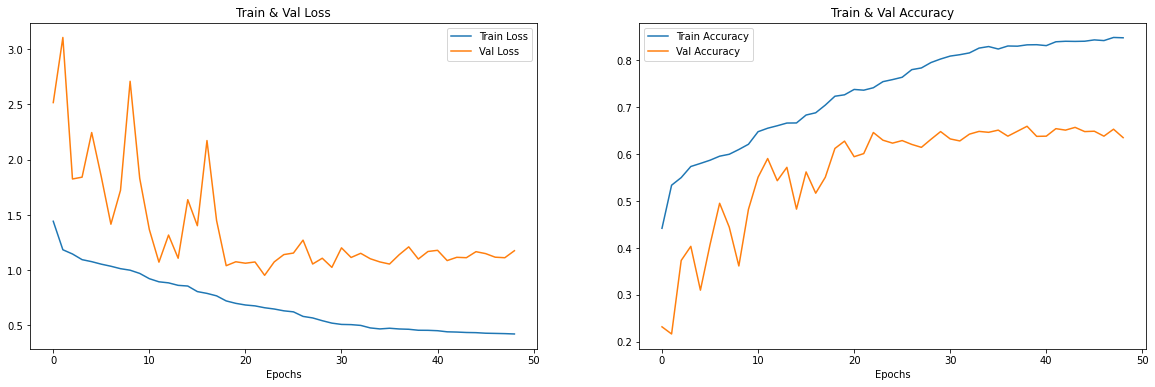

In [15]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Train Loss')
ax[0].plot(val_loss , label = 'Val Loss')
ax[0].set_title('Train & Val Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Train Accuracy')
ax[1].plot(val_acc , label = 'Val Accuracy')
ax[1].set_title('Train & Val Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [16]:
path_to_model = "./model_v1.h5"
model.save(path_to_model)